In [1]:
import os
import zipfile

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import torch.nn.functional as F

import torch
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from PIL import Image
import random



In [2]:
zip_path = "data.zip"  # replace with your uploaded file name

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(".")  # extracts to "unzipped_data" folder


In [3]:
# train_transforms  = transforms.Compose([
#     transforms.Grayscale(),           # Convert to 1 channel
#     # transforms.RandomHorizontalFlip(),           # Randomly flip images horizontally
#     # transforms.RandomRotation(10),               # Random rotation within ±10 degrees
#     # transforms.RandomResizedCrop(size=(30,30), antialias=False),  # Random crop with slight scaling
#     transforms.Resize((45, 45)),      # Match training size
#     # transforms.CenterCrop((28,28)),

#     # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),  # Slight color changes
#     transforms.ToTensor(),                       # Convert image to PyTorch tensor
#     transforms.Normalize((0.5,), (0.5,))         # Normalize (assuming grayscale, update if RGB)
# ])

# test_transforms = transforms.Compose([
#     transforms.Grayscale(),           # Convert to 1 channel
#     transforms.Resize((45, 45)),      # Match training size
#     # transforms.CenterCrop((28,28)),

#     transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,))
# ])


# class CustomScrabbleDataset(Dataset):
#     def __init__(self, root_dir, split='training', transform=None):
#         """
#         Args:
#             root_dir (str): Path to dataset root.
#             split (str): 'training' or 'val'.
#             transform (callable, optional): Optional transform to apply to images.
#         """
#         self.samples = []
#         self.labels = []
#         self.class_to_idx = {}
#         self.transform = transform

#         # Each class folder (A, B, ...)
#         for idx, class_name in enumerate(sorted(os.listdir(root_dir))):
#             class_path = os.path.join(root_dir, class_name, split)
#             if not os.path.isdir(class_path):
#                 continue

#             self.class_to_idx[class_name] = idx

#             for fname in os.listdir(class_path):
#                 if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
#                     self.samples.append(os.path.join(class_path, fname))
#                     self.labels.append(idx)

#     def __len__(self):
#         return len(self.samples)

#     def __getitem__(self, idx):
#         image_path = self.samples[idx]
#         label = self.labels[idx]

#         # Load the image using PIL
#         image = Image.open(image_path).convert("RGB")

#         if self.transform:
#             image = self.transform(image)

#         return image, label


# train_dataset = CustomScrabbleDataset('data', split='training', transform=train_transforms )
# val_dataset = CustomScrabbleDataset('data', split='val', transform=test_transforms)

# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# class_names = [
#     'A', 'B', 'C', 'D', 'E', 'F', 'G',
#     'H', 'I', 'J', 'K', 'L', 'M', 'N',
#     'O', 'P', 'Q', 'R', 'S', 'T', 'U',
#     'V', 'W', 'X', 'Y', 'Z'
# ]


In [4]:
# train_transform = transforms.Compose([
#     transforms.Grayscale(),
#     # transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
#     # transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
#     # transforms.RandomErasing(p=0.3, scale=(0.02, 0.1), ratio=(0.3, 3.3)),
#     transforms.Resize((45, 45)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,))
# ])

# val_test_transform = transforms.Compose([
#     transforms.Grayscale(),
#     transforms.Resize((45, 45)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,))
# ])


# dataset = ImageFolder('data', transform=train_transform)

# # Train/val/test split (70/15/15)
# total_size = len(dataset)
# train_size = int(0.7 * total_size)
# val_size = int(0.15 * total_size)
# test_size = total_size - train_size - val_size

# train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# # Update transforms for val/test sets (no augmentation)
# val_dataset.dataset.transform = val_test_transform
# test_dataset.dataset.transform = val_test_transform

# # Dataloaders
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#####################################################################################################

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((45, 45)),
    transforms.RandomRotation(5),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), shear=5),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# val_test_transform = transforms.Compose([
#     transforms.Grayscale(),
#     transforms.Resize((45, 45)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,))
# ])

class LetterDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        for class_name in os.listdir(root_dir):
            class_path = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_path):
                continue
            for fname in os.listdir(class_path):
                self.samples.append((os.path.join(class_path, fname), class_name))

        self.class_to_idx = {cls: idx for idx, cls in enumerate(sorted(set(label for _, label in self.samples)))}

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = Image.open(path).convert("L")
        if self.transform:
            image = self.transform(image)
        return image, self.class_to_idx[label], path

# dataset = LetterDataset("data", transform=transform)

# synth = "synth"

# clean_indices = [i for i, (_, _, path) in enumerate(dataset) if synth not in os.path.basename(path).lower()]

# val_size = len(clean_indices) // 2
# test_size = len(clean_indices) - val_size

# # Shuffle + split clean indices
# random.shuffle(clean_indices)
# val_indices = clean_indices[:val_size]
# test_indices = clean_indices[val_size:]

# all_indices = set(range(len(dataset)))
# train_indices = list(all_indices - set(val_indices) - set(test_indices))

# train_dataset = Subset(dataset, train_indices)
# val_dataset   = Subset(dataset, val_indices)
# test_dataset  = Subset(dataset, test_indices)

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
# test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)


##################################################################################################


dataset = LetterDataset("data", transform=transform)

real_indices = [i for i, (_, _, path) in enumerate(dataset) if "synth" not in os.path.basename(path).lower()]
synth_indices = [i for i, (_, _, path) in enumerate(dataset) if "synth" in os.path.basename(path).lower()]


random.shuffle(real_indices)

num_real = len(real_indices)
num_train_real = int(0.6 * num_real)
num_val_real = int(0.2 * num_real)

train_real_indices = real_indices[:num_train_real]
val_real_indices = real_indices[num_train_real:num_train_real + num_val_real]
test_real_indices = real_indices[num_train_real + num_val_real:]

train_indices = train_real_indices + synth_indices
val_indices = val_real_indices
test_indices = test_real_indices

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


class_names = [
    'A', 'B', 'C', 'D', 'E', 'F', 'G',
    'H', 'I', 'J', 'K', 'L', 'M', 'N',
    'O', 'P', 'Q', 'R', 'S', 'T', 'U',
    'V', 'W', 'X', 'Y', 'Z'
]

In [5]:
# class LetterClassifier(nn.Module):
#     def __init__(self):
#         super(LetterClassifier, self).__init__()
#         self.conv1 = nn.Conv2d(1, 8, 3)
#         self.conv2 = nn.Conv2d(8, 16, 3)
#         self.fc1 = nn.Linear(16 * 5 * 5, 64)
#         self.fc2 = nn.Linear(64, len(class_names))

#     def forward(self, x):
#         x = torch.relu(self.conv1(x))
#         x = torch.max_pool2d(x, 2)
#         x = torch.relu(self.conv2(x))
#         x = torch.max_pool2d(x, 2)
#         x = x.view(-1, 16 * 5 * 5)
#         x = torch.relu(self.fc1(x))
#         return self.fc2(x)


# class LetterClassifier(nn.Module):
#     def __init__(self):
#         super(LetterClassifier, self).__init__()
#         self.conv1 = nn.Conv2d(1, 32, 3)
#         self.conv2 = nn.Conv2d(32, 64, 3)
#         self.fc1 = nn.Linear(64 * 5 * 5, 128)
#         self.fc2 = nn.Linear(128, len(class_names))

#     def forward(self, x):
#         x = torch.relu(self.conv1(x))
#         x = torch.max_pool2d(x, 2)
#         x = torch.relu(self.conv2(x))
#         x = torch.max_pool2d(x, 2)
#         x = x.view(-1, 64 * 5 * 5)
#         x = torch.relu(self.fc1(x))
#         return self.fc2(x)


# class LetterClassifier(nn.Module):
#     def __init__(self):
#         super(LetterClassifier, self).__init__()
#         self.conv1 = nn.Conv2d(1, 32, 3)
#         self.conv2 = nn.Conv2d(32, 64, 3)
#         self.fc1 = nn.Linear(64 * 9 * 9, 128)  # updated for 45x45 input
#         self.fc2 = nn.Linear(128, len(class_names))

#     def forward(self, x):
#         x = torch.relu(self.conv1(x))
#         x = torch.max_pool2d(x, 2)
#         x = torch.relu(self.conv2(x))
#         x = torch.max_pool2d(x, 2)
#         x = x.view(-1, 64 * 9 * 9)  # updated
#         x = torch.relu(self.fc1(x))
#         return self.fc2(x)

# class LetterClassifier(nn.Module):
#     def __init__(self):
#         super(LetterClassifier, self).__init__()
#         self.conv1 = nn.Conv2d(1, 8, 3)
#         self.conv2 = nn.Conv2d(8, 16, 3)
#         self.fc1 = nn.Linear(16 * 9 * 9, 64)  # <-- updated
#         self.fc2 = nn.Linear(64, len(class_names))

#     def forward(self, x):
#         x = torch.relu(self.conv1(x))
#         x = torch.max_pool2d(x, 2)
#         x = torch.relu(self.conv2(x))
#         x = torch.max_pool2d(x, 2)
#         x = x.view(-1, 16 * 9 * 9)  # <-- this stays the same
#         x = torch.relu(self.fc1(x))
#         return self.fc2(x)

class LetterClassifier(nn.Module):
    def __init__(self):
        super(LetterClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)
        self.fc1 = nn.Linear(16 * 9 * 9, 64)  # Based on 45x45 input
        self.dropout = nn.Dropout(0.5)        # Dropout to reduce overfitting
        self.fc2 = nn.Linear(64, len(class_names))

    def forward(self, x):
        x = F.relu(self.conv1(x))       # -> [B, 8, 43, 43]
        x = F.max_pool2d(x, 2)          # -> [B, 8, 21, 21]
        x = F.relu(self.conv2(x))       # -> [B, 16, 19, 19]
        x = F.max_pool2d(x, 2)          # -> [B, 16, 9, 9]
        x = x.view(x.size(0), -1)       # Flatten: [B, 16*9*9]
        x = self.dropout(F.relu(self.fc1(x)))
        return self.fc2(x)



In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_accuracy(model, set_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels, _ in set_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

EPOCH 0 COMPLETE! TRAIN: 37.29635523224975. VAL: 60.84583901773534
EPOCH 1 COMPLETE! TRAIN: 53.65613396984163. VAL: 75.57980900409277
EPOCH 2 COMPLETE! TRAIN: 59.57414563916041. VAL: 80.90040927694406
EPOCH 3 COMPLETE! TRAIN: 64.64347957869212. VAL: 82.67394270122783
EPOCH 4 COMPLETE! TRAIN: 67.68204895051906. VAL: 83.08321964529331
EPOCH 5 COMPLETE! TRAIN: 67.4168371599606. VAL: 85.40245566166439
EPOCH 6 COMPLETE! TRAIN: 70.67515344396453. VAL: 87.03956343792633
EPOCH 7 COMPLETE! TRAIN: 73.92589224823824. VAL: 89.7680763983629
EPOCH 8 COMPLETE! TRAIN: 74.03197696446162. VAL: 88.94952251023193
EPOCH 9 COMPLETE! TRAIN: 76.91141926195347. VAL: 90.85948158253751
EPOCH 10 COMPLETE! TRAIN: 77.82829430931272. VAL: 91.81446111869032
EPOCH 11 COMPLETE! TRAIN: 78.65423959990908. VAL: 93.04229195088676
EPOCH 12 COMPLETE! TRAIN: 80.41979237705539. VAL: 93.99727148703957
EPOCH 13 COMPLETE! TRAIN: 81.62461165416383. VAL: 94.1336971350614
EPOCH 14 COMPLETE! TRAIN: 82.26111995150413. VAL: 95.08867667

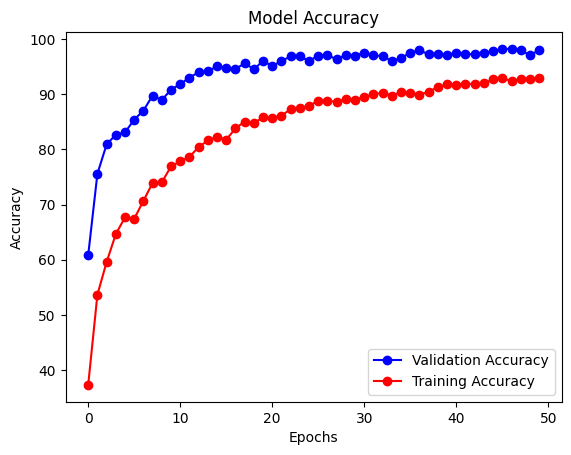

In [7]:
model = LetterClassifier().to(device)

criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=5e-5)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

val_accs = []
training_accs = []

num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels, _ in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

    val_acc = get_accuracy(model, val_loader)
    train_acc = get_accuracy(model, train_loader)

    val_accs.append(val_acc)
    training_accs.append(train_acc)

    print(f"EPOCH {epoch} COMPLETE! TRAIN: {train_acc}. VAL: {val_acc}")

x = [i for i in range(num_epochs)]
# Plot both sets of data
plt.plot(x, val_accs, label='Validation Accuracy', color='blue', marker='o')
plt.plot(x, training_accs, label='Training Accuracy', color='red', marker='o')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.show()

In [8]:


# num_epochs = 100

# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     for images, labels in train_loader:
#         images, labels = images.to(device), labels.to(device)

#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()

#         optimizer.step()

#         running_loss += loss.item()

#     val_acc = get_accuracy(model, val_loader)
#     train_acc = get_accuracy(model, train_loader)

#     val_accs.append(val_acc)
#     training_accs.append(train_acc)

#     print(f"EPOCH {epoch} COMPLETE! TRAIN: {train_acc}. VAL: {val_acc}")

# x = [i for i in range(num_epochs + 50)]
# # Plot both sets of data
# plt.plot(x, val_accs, label='Validation Accuracy', color='blue', marker='o')
# plt.plot(x, training_accs, label='Training Accuracy', color='red', marker='o')

# # Add labels and title
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.title('Model Accuracy')
# plt.legend()  # Show legend

# # Show the plot
# plt.show()


Classification Report:

              precision    recall  f1-score   support

           A       1.00      1.00      1.00        23
           B       1.00      1.00      1.00        25
           C       0.88      1.00      0.94        29
           D       1.00      0.94      0.97        36
           E       1.00      1.00      1.00        20
           F       1.00      1.00      1.00        26
           G       1.00      0.97      0.98        33
           H       0.97      0.91      0.94        32
           I       0.90      1.00      0.95        19
           J       1.00      1.00      1.00        28
           K       0.93      1.00      0.97        28
           L       1.00      1.00      1.00        35
           M       0.97      0.94      0.95        32
           N       1.00      0.91      0.95        22
           O       0.87      0.91      0.89        22
           P       1.00      1.00      1.00        26
           Q       0.97      0.93      0.95        30
  

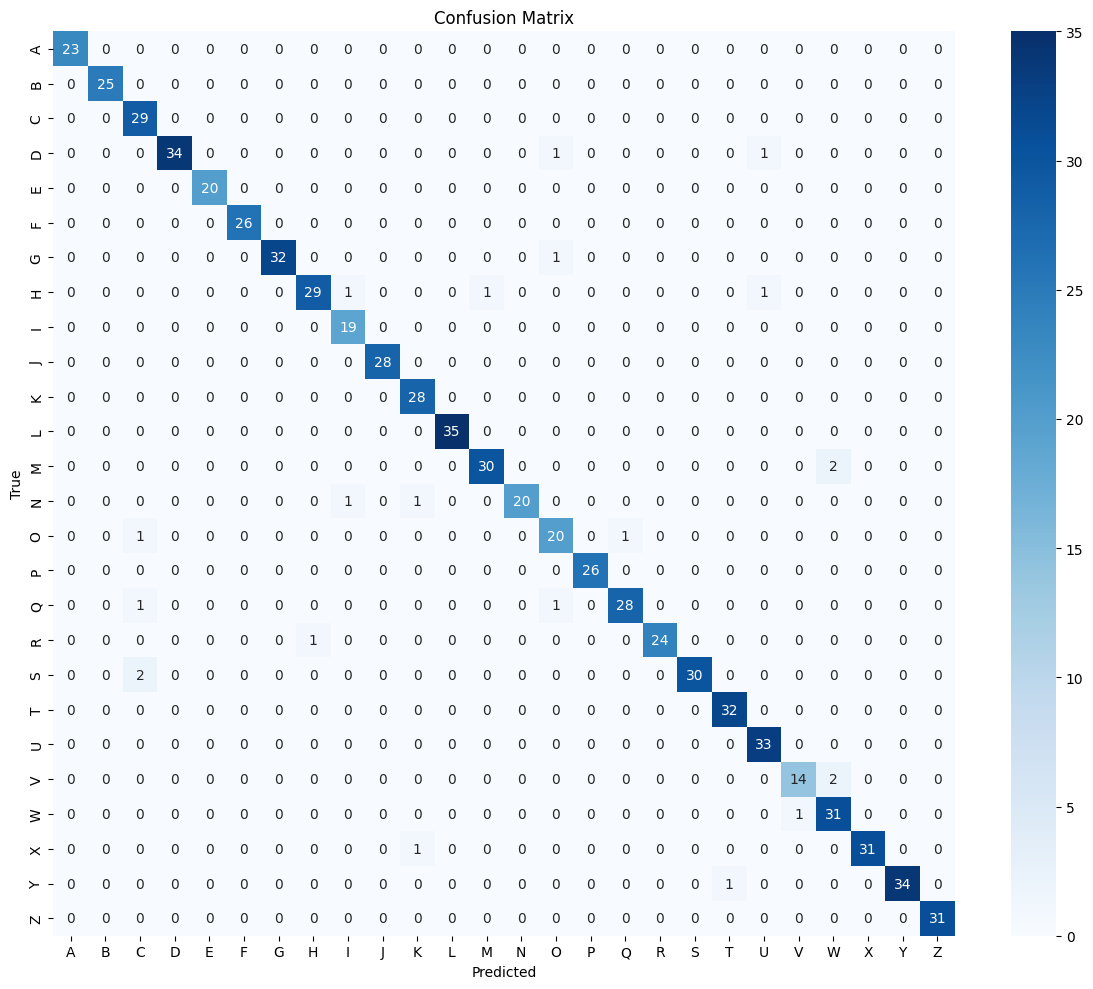

In [9]:

# Set model to evaluation mode

model.eval()

# Lists to store ground truth and predictions
y_true = []
y_pred = []

# Disable gradient computation
with torch.no_grad():
    for inputs, labels, _ in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Get class names from dataset
# class_names = test_dataset.dataset.classes  # ImageFolder keeps class-to-index

# Print classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [10]:
torch.save(model.state_dict(), 'letter_classifier_3.pth')
